# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./"

In [4]:
test_df = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
train_df = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
## your code
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

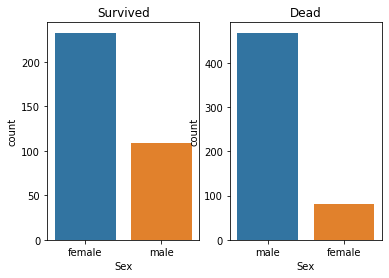

In [7]:
plt.subplot(1,2,1)
plt.title('Survived')
ax1 = sns.countplot(x="Sex", data=train_df[train_df["Survived"]==1])

plt.subplot(1,2,2)
plt.title('Dead')
ax2 = sns.countplot(x="Sex", data=train_df[train_df["Survived"]==0])

There is a big relationship between the gender and the survival, as we can see many female where survived, because the captain ordered to place women and children in the lifeboats first of all.

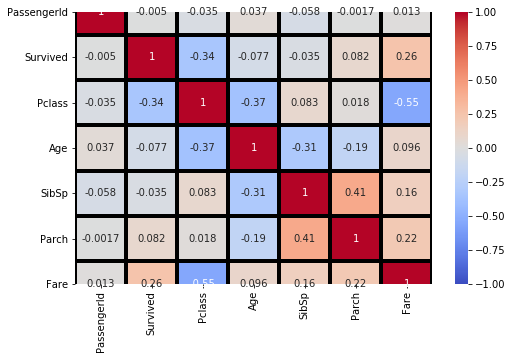

In [8]:
plt.figure(figsize=(8,5))
sns.heatmap(train_df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [9]:
## your code
age = train_df.copy()

In [10]:
bins = [0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']

In [11]:
age['AgeGroup'] = pd.cut(age["Age"], bins, labels = labels)

E:\Install\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


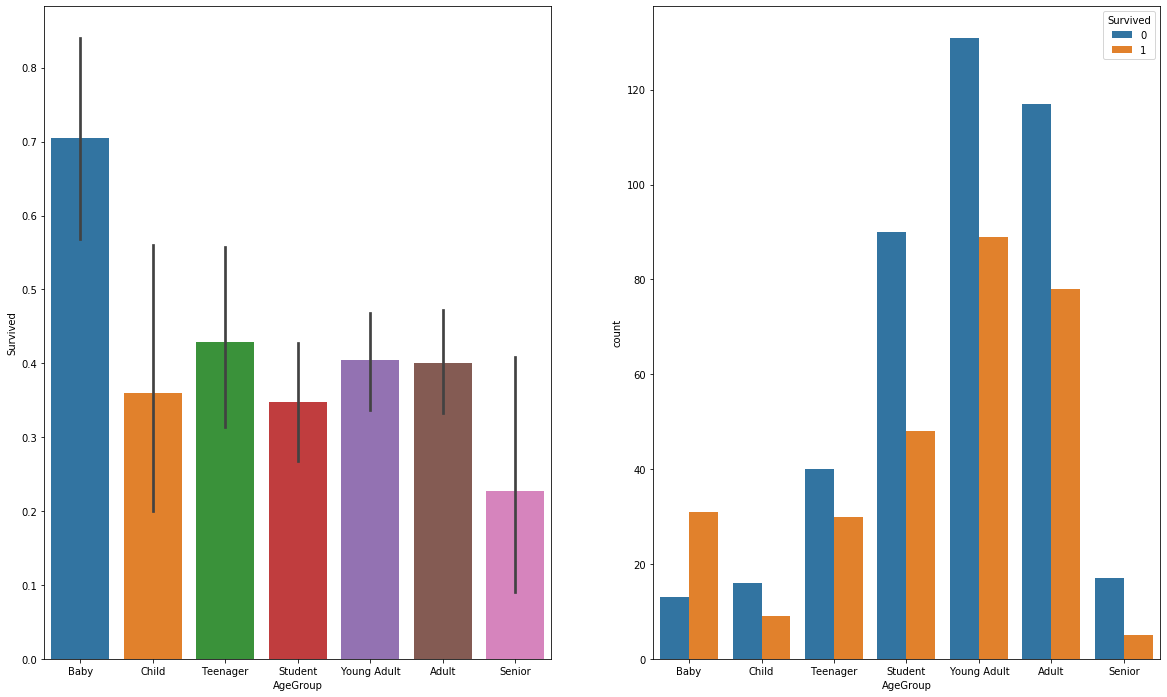

In [12]:
plt.figure(figsize = (20, 12))

plt.subplot(1, 2, 1)
sns.barplot(x="AgeGroup", y="Survived", data=age)

plt.subplot(1, 2, 2)
sns.countplot('AgeGroup', data = age, hue = "Survived")

plt.show()

In [13]:
pd.crosstab( [age.Survived], [age.AgeGroup], margins = True)

AgeGroup,Baby,Child,Teenager,Student,Young Adult,Adult,Senior,All
Survived,,,,,,,,
0,13,16,40,90,131,117,17,424
1,31,9,30,48,89,78,5,290
All,44,25,70,138,220,195,22,714


In [14]:
survived_passengers = age[age['Survived']==1]['Age']
dead_passengers = age[age['Survived']==0]['Age']
print("average age:" ,survived_passengers.mean())
print("median age:" ,survived_passengers.median())
print("average age:" ,dead_passengers.mean())
print("median age:" ,dead_passengers.median())

average age: 28.343689655172415
median age: 28.0
average age: 30.62617924528302
median age: 28.0


"Baby"(1-5 years) were most likely to survive.
Other groups had less than 50% chance of survival.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

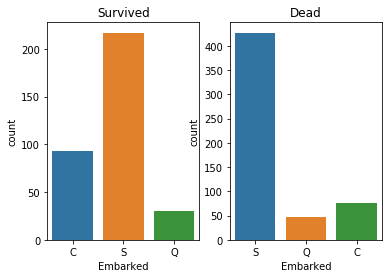

In [15]:
## your code
plt.subplot(1,2,1)
plt.title('Survived')
ax1 = sns.countplot(x="Embarked", data=train_df[train_df["Survived"]==1])

plt.subplot(1,2,2)
plt.title('Dead')
ax2 = sns.countplot(x="Embarked", data=train_df[train_df["Survived"]==0])

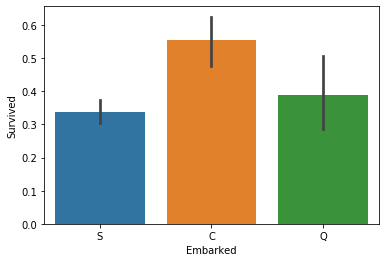

In [16]:
sns.barplot(x='Embarked', y='Survived', data=train_df)

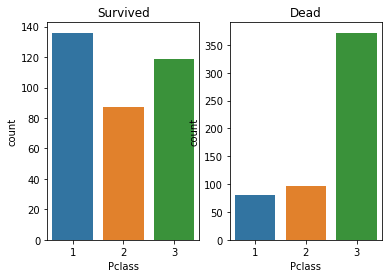

In [17]:
plt.subplot(1,2,1)
plt.title('Survived')
ax1 = sns.countplot(x="Pclass", data=train_df[train_df["Survived"]==1])

plt.subplot(1,2,2)
plt.title('Dead')
ax2 = sns.countplot(x="Pclass", data=train_df[train_df["Survived"]==0])

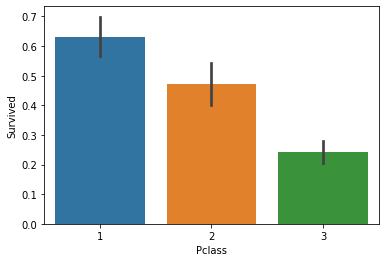

In [18]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

As you can see in the graphs, people who boarded the ship in Port C will survive the most.
1 class is the safest

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [19]:
## your code
print("Total number of rows in train data: ", len(train_df))
na_train= train_df.columns[train_df.isna().any()]
print("NA values in train dataset:")
for col in na_train:
    print(col,sum(train_df.loc[:,col].isna()),",",round(sum(train_df.loc[:,col].isna())/len(train_df)*100,2),"% of data")

Total number of rows in train data:  891
NA values in train dataset:
Age 177 , 19.87 % of data
Cabin 687 , 77.1 % of data
Embarked 2 , 0.22 % of data


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

A cabin number looks like "C123" and the letter refers to the deck. Therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero.
Age we fill in with the average.
Embarked fill in with common value.
Disadvantage : Summarizing data containing important information, it may cost worse prediction quality. If it was big dataset we can just drop thi columns.
Advantage : we simplify the values "cabin" just to know the floor. A detailed description of where the cabin is located is not very important, as I think.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [20]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)

In [21]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

In [22]:
common_value = 'S'

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [23]:
genders = {"male": 0, "female": 1}
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [24]:
ports = {"S": 0, "C": 1, "Q": 2}

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [25]:
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [26]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [27]:
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [28]:
#y = data['Survived']
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.copy()

In [29]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [30]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_scaled_train, Y_train)

Y_pred = logreg.predict(X_scaled_test)

acc_log = round(logreg.score(X_scaled_train, Y_train) * 100, 2)
acc_log

81.26

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2) 
knn.fit(X_scaled_train, Y_train)
Y_pred_knn = knn.predict(X_test)  
acc_knn = round(knn.score(X_scaled_train, Y_train) * 100, 2)
acc_knn

88.33

In [32]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X_scaled_train, Y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.82681564 0.80337079 0.78089888 0.81460674 0.82022472]
Mean: 0.8091833532107213


In [33]:
scores = cross_val_score(knn, X_scaled_train, Y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.72067039 0.8258427  0.7752809  0.79213483 0.83146067]
Mean: 0.7890778984370096


add features

In [34]:
data = [train_df, test_df]
for dataset in data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [35]:
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

In [36]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [37]:
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [38]:
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [39]:
test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,FamilySize,relatives,not_alone,Fare_Per_Person
0,892,3,0,5,0,0,0,2,8,1,1,0,1,7
1,893,3,1,6,1,0,0,0,8,3,2,1,0,3
2,894,2,0,6,0,0,1,2,8,1,1,0,1,9
3,895,3,0,3,0,0,1,0,8,1,1,0,1,8
4,896,3,1,2,1,1,1,0,8,3,3,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,3,0,0,1,0,8,1,1,0,1,8
414,1306,1,1,5,0,0,4,1,3,5,1,0,1,108
415,1307,3,0,5,0,0,0,0,8,1,1,0,1,7
416,1308,3,0,3,0,0,1,0,8,1,1,0,1,8


In [40]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.copy()

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [41]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled_train_f = scaler.transform(X_train)
X_scaled_test_f = scaler.transform(X_test)

In [42]:
logreg_f = LogisticRegression(solver='liblinear', penalty='l2')
logreg_f.fit(X_train, Y_train)

Y_pred_f = logreg_f.predict(X_test)

acc_log = round(logreg_f.score(X_train, Y_train) * 100, 2)
acc_log

81.48

In [43]:
knn_f = KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski', n_jobs=1, n_neighbors=11, p=2, weights='uniform')
knn_f.fit(X_scaled_train_f, Y_train)
Y_pred_knn_f = knn_f.predict(X_scaled_test_f)  
acc_knn = round(knn_f.score(X_scaled_train_f, Y_train) * 100, 2)
acc_knn

84.74

In [44]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg_f, X_train, Y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.82122905 0.81460674 0.78651685 0.80337079 0.8258427 ]
Mean: 0.8103132257862031


In [45]:
scores = cross_val_score(knn_f,X_scaled_train_f, Y_train, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())

Scores: [0.80446927 0.80898876 0.82022472 0.79775281 0.84831461]
Mean: 0.8159500345238841


In [46]:
## your code
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_f
    })

In [47]:
submission.to_csv('submission.csv', index=False)#score ~0.782

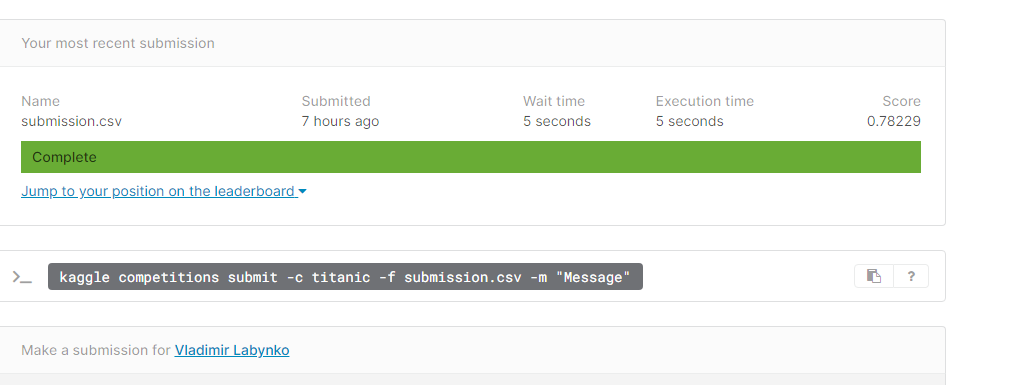

In [6]:
from IPython.display import Image
Image("score.png")

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

 Not Done

In [48]:
insurance_data = pd.read_csv('train.csv').set_index('id')

In [49]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [50]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [51]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [53]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [54]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))


0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

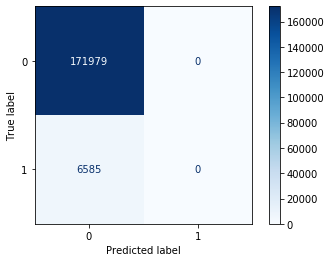

In [55]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [56]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

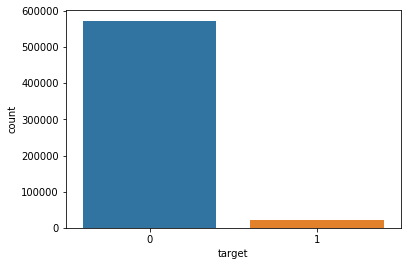

In [57]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [58]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Gini coefficient shows proportion (cumulative) of good answer instead of all answer. It shows the extent to which the model has better classification capabilities in comparison to the random model. It is also called Gini Index. Gini Coefficient can take values between -1 and 1. Negative values correspond to a model with reversed meanings of scores.
AUC or ROC curve shows proportion of true positives  versus the proportion of false positives 
If you reverse the axis of chart in Gini plot, you would get similar to the chart AUC plot. 

***See abstract "The relationship between Gini terminology and the
ROC curve" by Edna Schechtman and Gideon Schechtman***

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [59]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [60]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.